In [1]:
%load_ext autoreload
%autoreload 2
import copy
import gc
import sys

sys.path.append('..')

import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, 
                                     cross_val_score)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from lightgbm import LGBMRegressor

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

from src.utils.cross_validation import TimeSeriesGroupSplit
from src.utils.downcasting import downcast_dtypes

sns.set(font_scale=1.2)
%matplotlib inline

In [2]:
max_text_features = 20
random_state = 42

BEST_CONSTANT = 0.2839
MEAN_CONSTANT = 0.3343

# LightGBM

In this notebook we will produce predictions by LightGBM.

## Preparing datasets

In this section we will load all datasets and prepare them for training.

In [3]:
sales_train = pd.read_csv('../data/processed/sales_train.csv')
train = pd.read_feather('../data/processed/train.ftr')
test = pd.read_feather('../data/processed/test.ftr')

items = pd.read_csv('../data/processed/items.csv')
tfidf_truncated_svd = pd.read_feather('../data/processed/text/tfidf_truncated-svd.ftr')

In [4]:
train.drop(columns=['index'], inplace=True)
test.drop(columns=['index', 'level_0'], inplace=True)

### Adding text features

In [6]:
tfidf_truncated_svd = tfidf_truncated_svd[tfidf_truncated_svd.columns[:max_text_features]]

In [7]:
tfidf_truncated_svd['item_id'] = items.item_id

In [8]:
train = pd.merge(
    train,
    tfidf_truncated_svd,
    how='left', on='item_id'
)

test = pd.merge(
    test,
    tfidf_truncated_svd,
    how='left', on='item_id'
)

gc.collect();

### Clipping target

According to evaluation, target will be clipped between 0 and 20. Let's do it in our dataset.

In [9]:
train.target = np.clip(train.target, 0, 20)

### Process categorical data

Find categorical columns.

In [10]:
categorical_types = ['object', 'bool']

In [11]:
train.dtypes[np.isin(train.dtypes.values, categorical_types)]

item_name                  object
item_in_test                 bool
item_full_category_name    object
item_category_name         object
item_subcategory_name      object
shop_name                  object
city                       object
shop_in_test                 bool
dtype: object

Don't touch boolean objects, they are already label encoded.

Let's remove columns `item_name`, `shop_name`, because we already have them label encoded as `item_id`, `shop_id`.

In [12]:
train.drop(columns=['item_name', 'shop_name'], inplace=True)
test.drop(columns=['item_name', 'shop_name'], inplace=True)

Let's define list with all categorical values.

In [13]:
categorical_features = [
    'month', 'item_id', 'item_full_category_name', 'item_category_name', 
    'item_subcategory_name', 'shop_id', 'city'
]

#### Label encoding

We will label encode only `city`, because in other cases we have already label encoded features or there are values on test, that are not present on train.

In [14]:
label_encode_features = ['city']

for column in label_encode_features:
    le = LabelEncoder()
    
    encoded_feature_train = le.fit_transform(train[column])
    train[f'{column}_labeled'] = encoded_feature_train
    
    encoded_feature_test = le.transform(test[column])
    test[f'{column}_labeled'] = encoded_feature_test

#### Mean encoding

In [15]:
for column in tqdm(categorical_features):
    # encode train
    cumsum = train.groupby(column).target.cumsum() - train.target
    cumcount = train.groupby(column).cumcount()
    encoded_feature = cumsum / cumcount
    encoded_feature.fillna(MEAN_CONSTANT, inplace=True)
    
    train[f'{column}_mean_encoded_mean'] = encoded_feature
    
    # encode test
    mean_train = train.groupby(column).target.mean()
    test[f'{column}_mean_encoded_mean'] = test[column].map(mean_train).fillna(MEAN_CONSTANT)

Drop all redundant columns.

In [16]:
to_drop = ['item_id', 'item_full_category_name', 'item_category_name', 
           'item_subcategory_name', 'city']
train.drop(columns=to_drop, inplace=True)
test.drop(columns=to_drop, inplace=True)

### Processing NaNs

Fill NaNs.

In [17]:
train.columns[train.isna().sum() > 0]

Index(['num_residents'], dtype='object')

As we expected there are some problems only with `num_residents`. We can fill it with zero, because it will be border value for this feature, trees can handle it properly.

In [18]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

### Removing target

Remove target from train.

In [19]:
y = train.target
train.drop(columns=['target'], inplace=True)

### Creation of validation split

Let's also delete from train rows that appears only on validation, it will make our train/validation split more consistant with train/test split.

In [20]:
X_valid = train[train.date_block_num == 33]
X_train = train[train.date_block_num < 33]
y_valid = y[train.date_block_num == 33]
y_train = y[train.date_block_num < 33]
X_test = test
    
del train, test
gc.collect()

39

## Hyperparameters tuning

In this section we will find optimum parameters for a model. Firstly, fix the result before any optimization.

In [21]:
ts = TimeSeriesGroupSplit(n_splits=5, max_train_size=int(1.5*10**6))

lgb_params = {
    'objective': 'rmse',
    'learning_rate': 0.1,
    'random_state': random_state
}

In [22]:
for train_idx, test_idx in ts.split(X_train, groups=X_train.date_block_num):
    print(f'Train blocks size: {X_train.iloc[train_idx].date_block_num.nunique()}')
    print(f'Test blocks size: {X_train.iloc[test_idx].date_block_num.nunique()}')

Train blocks size: 4
Test blocks size: 3
Train blocks size: 5
Test blocks size: 3
Train blocks size: 5
Test blocks size: 3
Train blocks size: 5
Test blocks size: 3
Train blocks size: 6
Test blocks size: 3


In [23]:
# default_score = cross_val_score(
#     LGBMRegressor(**lgb_params), 
#     X_train, y_train, groups=X_train.date_block_num,
#     n_jobs=1, 
#     scoring='neg_root_mean_squared_error', 
#     verbose=0,
#     cv=ts
# ).mean()
# print(f'Default score: {-default_score:.5f}')

Score: $0.90079$.

### `n_estimators`

In this section we fix `learning_rate = 0.1` and try to find reasonable num of iterations.

In [24]:
# X_train_dataset = lgb.Dataset(X_train[X_train.date_block_num >= 25], label=y_train[X_train.date_block_num >= 25])
# X_valid_dataset = lgb.Dataset(X_valid, label=y_valid)

# lgb.train(lgb_params, X_train_dataset, num_boost_round=1000, 
#           valid_sets=[X_train_dataset, X_valid_dataset], early_stopping_rounds=100)

# del X_train_dataset, X_valid_dataset
# gc.collect();

In [25]:
param_grid = {
    'n_estimators': np.arange(50, 301, 50)
}

gs = GridSearchCV(
    LGBMRegressor(**lgb_params), 
    param_grid,          
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=10,
    refit=False,
    cv=ts
)

gs.fit(X_train, y_train, groups=X_train.date_block_num)

gs.cv_results_

gs.best_params_

In [26]:
lgb_params['n_estimators'] = 100

### Tree parameters

Here we will find optimum values for building tree:
* `num_leaves`
* `max_depth`
* `min_data_in_leaf`

In [27]:
def objective(params):
    """Function to optimize in hyperopt."""
    # all our parameters are integer
    params = {key: int(value) for key, value in params.items()}
    
    current_params = copy.copy(lgb_params)
    current_params.update(params)    
    score = cross_val_score(
        LGBMRegressor(**current_params), 
        X_train, y_train, groups=X_train.date_block_num,
        n_jobs=1, 
        scoring='neg_root_mean_squared_error', 
        verbose=0,
        cv=ts
    ).mean()
    
    print(f'RMSE {-score:.5f} params {params}')
    
    return {
        'loss': -score,
        'status': STATUS_OK,
    }

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2), 
    'max_depth': hp.choice(
        'max_depth', [-1, hp.quniform('max_depth_limited', 4, 20, 2)]
    ),
    'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 1, 4, 4)
}

np.random.seed(random_state)
trials = Trials()
best = fmin(
    fn=objective, 
    space=space, 
    algo=tpe.suggest, 
    max_evals=30,
    trials=trials
)

best

if best['max_depth'] == 0:
    lgb_params['max_depth'] = -1
else:
    lgb_params['max_depth'] = int(best['max_depth_limited'])
    
lgb_params['min_data_in_leaf'] = int(best['min_data_in_leaf'])
lgb_params['num_leaves'] = int(best['num_leaves'])

In [28]:
lgb_params['max_depth'] = 14# 6
lgb_params['min_data_in_leaf'] = 44#36
lgb_params['num_leaves'] = 56

In [29]:
lgb_params

{'objective': 'rmse',
 'learning_rate': 0.1,
 'random_state': 42,
 'n_estimators': 100,
 'max_depth': 14,
 'min_data_in_leaf': 44,
 'num_leaves': 56}

### Subsampling

Here we will find optimum parameters for subsampling:
* `bagging_fraction`
* `feature_fraction`

In [30]:
param_grid = {
    'bagging_fraction': np.linspace(0.2, 1, 5),
    'feature_fraction': np.linspace(0.2, 1, 5)
}

gs = GridSearchCV(
    LGBMRegressor(**lgb_params), 
    param_grid,          
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=10,
    refit=False,
    cv=ts
)

gs.fit(X_train, y_train, groups=X_train.date_block_num)

gs.best_params_

gs.cv_results_

gs.best_score_

In [31]:
lgb_params['bagging_fraction'] = 1
lgb_params['feature_fraction'] = 1

In [32]:
lgb_params

{'objective': 'rmse',
 'learning_rate': 0.1,
 'random_state': 42,
 'n_estimators': 100,
 'max_depth': 14,
 'min_data_in_leaf': 44,
 'num_leaves': 56,
 'bagging_fraction': 1,
 'feature_fraction': 1}

### Regularization

In [33]:
lgb_params

{'objective': 'rmse',
 'learning_rate': 0.1,
 'random_state': 42,
 'n_estimators': 100,
 'max_depth': 14,
 'min_data_in_leaf': 44,
 'num_leaves': 56,
 'bagging_fraction': 1,
 'feature_fraction': 1}

Here we will find optimum parameters for regularization:
* `lambda_l1`
* `lambda_l2`

In [34]:
param_grid = {
    'lambda_l1': [0, 10**(-2), 10**(-1), 1, 10],
    'lambda_l2': [0, 10**(-2), 10**(-1), 1, 10]
}

gs = GridSearchCV(
    LGBMRegressor(**lgb_params), 
    param_grid,          
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=10,
    refit=False,
    cv=ts
)

gs.fit(X_train, y_train, groups=X_train.date_block_num)

gs.best_params_

gs.best_score_

gs.cv_results_

lgb_params['lambda_l1'] = gs.best_params_['lambda_l1']
lgb_params['lambda_l2'] = gs.best_params_['lambda_l2']

In [35]:
lgb_params['lambda_l1'] = 0.1
lgb_params['lambda_l2'] = 0.1

### Reduce learning rate

Current score:

In [36]:
# current_score = cross_val_score(
#     LGBMRegressor(**lgb_params), 
#     X_train, y_train, groups=X_train.date_block_num,
#     n_jobs=1, 
#     scoring='neg_root_mean_squared_error', 
#     verbose=0,
#     cv=ts
# ).mean()
# print(f'Current score: {-current_score:.5f}')

Score: $0.89673$.

Now we can half our `learning rate` and double `num_iterations`.

In [37]:
lgb_params_changed = copy.copy(lgb_params)
lgb_params_changed['learning_rate'] /= 2
lgb_params_changed['n_estimators'] = int(lgb_params['n_estimators'] * 2)

In [38]:
# score_after_change = cross_val_score(
#     LGBMRegressor(**lgb_params_changed), 
#     X_train, y_train, groups=X_train.date_block_num,
#     n_jobs=1, 
#     scoring='neg_root_mean_squared_error', 
#     verbose=0,
#     cv=ts
# ).mean()

# print(f'Score after changing: {-score_after_change:.5f}')

Score: $0.89335$.

It helped.

In [39]:
lgb_params = lgb_params_changed

## Validation

In this section we will validate best parameters using haldout. We will use not all train, because of limitation of RAM.

In [40]:
(X_train.date_block_num >= 25).sum()

1627417

In [41]:
start_date_block_num = 25
indices_train = (X_train.date_block_num >= start_date_block_num)
X_train = X_train[indices_train]
y_train = y_train[indices_train]
gc.collect();

In [42]:
model = LGBMRegressor(**lgb_params)
model.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=1, feature_fraction=1, lambda_l1=0.1,
              lambda_l2=0.1, learning_rate=0.05, max_depth=14,
              min_data_in_leaf=44, n_estimators=200, num_leaves=56,
              objective='rmse', random_state=42)

In [43]:
y_predicted = np.clip(model.predict(X_valid), 0, 20)
validation_score = mean_squared_error(y_valid, y_predicted)
print(f'Validation score: {validation_score:.5f}')

Validation score: 0.85948


Score: $0.85948$

Let's look at predicted values charasteristics.

In [44]:
pd.Series(y_predicted).describe()

count    168139.000000
mean          0.367578
std           0.962211
min           0.000000
25%           0.042015
50%           0.133769
75%           0.321412
max          20.000000
dtype: float64

Let's look at feature importances.

In [40]:
# lgb.plot_importance(model.booster_, figsize=(20, 20))
# plt.savefig('../reports/figures/lgb/importances.png', facecolor='white', 
#             bbox_inches='tight', pad_inches=0)

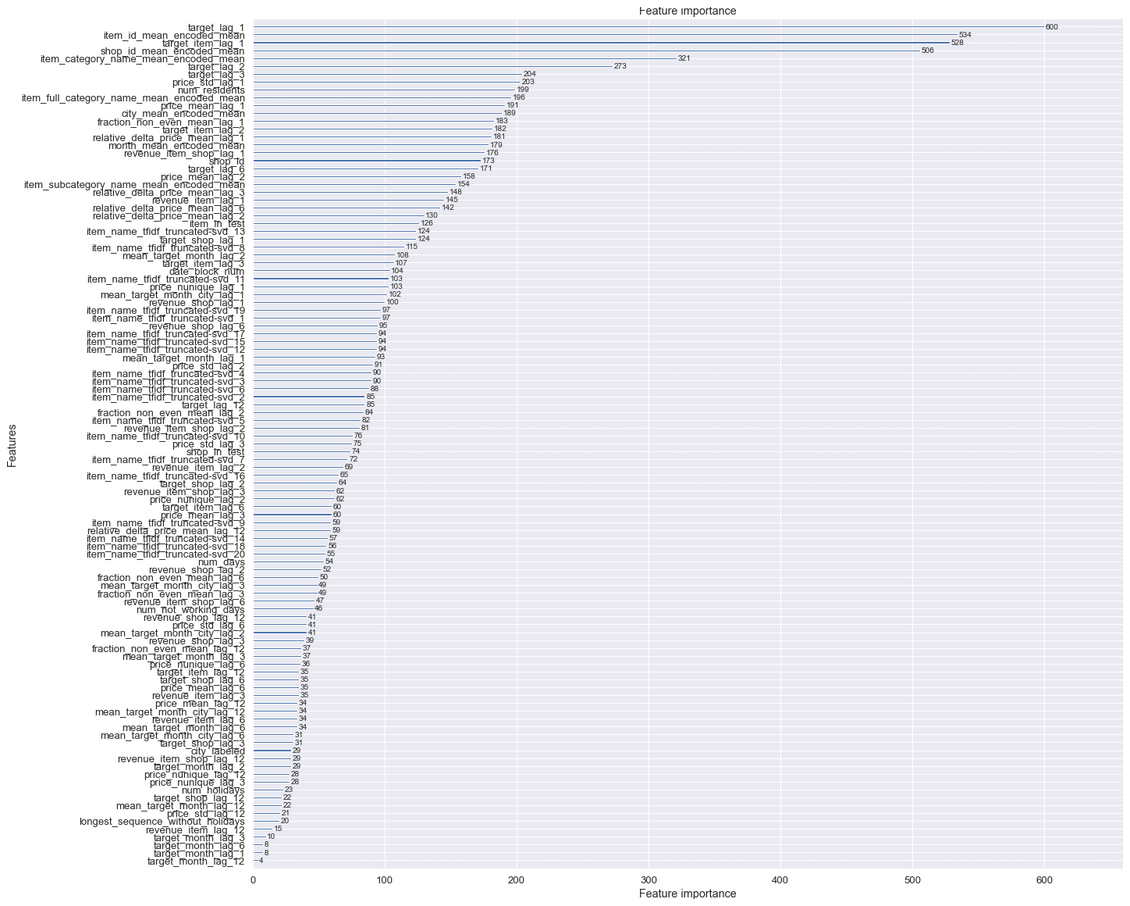

In [41]:
plt.figure(figsize=(20, 20))
image = plt.imread('../reports/figures/lgb/importances.png')
plt.imshow(image, interpolation='spline36')
plt.axis('off')
plt.show()

## Submit

In this section we will train result model and submit prediction. Don't forget to clip values according to [evaluation tab](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview/evaluation) (but ay be for tree-based methods it is not necessary).

In [42]:
X_train = pd.concat((X_train, X_valid))
y_train = pd.concat((y_train, y_valid))
gc.collect();

In [43]:
X_train.shape

(5667543, 109)

In [49]:
start_date_block_num = 25
indices_train = (X_train.date_block_num >= start_date_block_num)
X_train = X_train[indices_train]
y_train = y_train[indices_train]
gc.collect();

In [50]:
model = LGBMRegressor(**lgb_params)
bags = 5

bagged_predictions = np.zeros(X_test.shape[0])
for n in tqdm(range(bags)):
    model.set_params(random_state=random_state+n)
    model.fit(X_train, y_train)
    bagged_predictions += np.clip(model.predict(X_test), 0, 20)
    gc.collect()
    
bagged_predictions /= bags

Create submission.

In [51]:
pd.Series(bagged_predictions).describe()

count    214200.000000
mean          0.376339
std           0.734310
min           0.000000
25%           0.110090
50%           0.195049
75%           0.395269
max          20.000000
dtype: float64

In [52]:
submission = pd.read_csv('../data/raw/sample_submission.csv')
submission['item_cnt_month'] = bagged_predictions
submission.to_csv('../models/lgb/submission.csv', index=False)

!kaggle competitions submit competitive-data-science-predict-future-sales -f ../models/lgb/submission.csv -m "LightGBM"

Result is $1.00091$. It is pretty far from top positions.

## OOF predictions

In this section we will create out-of-fold predictions for stacking. We will use cheme f), that was given in the course:
> In time-series task we usually have a fixed period of time we are asked to predict. Like day, week, month or arbitrary period with duration of T.
> 1. Split the train data into chunks of duration T. Select first M chunks.
> 2. Fit N diverse models on those M chunks and predict for the chunk M+1. Then fit those models on first M+1 chunks and predict for chunk M+2 and so on, until you hit the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test.
> 3. Now we can use meta-features from first K chunks [M+1,M+2,..,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1. with the lesser amount of chunks and meta-features instead of features.

In [44]:
X_all = pd.concat((X_train, X_test))
test_size = X_test.shape[0]
del X_train, X_test
gc.collect();

In [45]:
num_blocks = X_all.date_block_num.nunique()
ts = TimeSeriesGroupSplit(n_splits=num_blocks-1, max_train_size=int(1.5*10**6))

We will use chunks, devided by `date_block_num`. In our case $M = 3$, but we won't use all previous chunks to train and limit it according to `max_train_size`.

In [46]:
model = LGBMRegressor(**lgb_params)

predictions = np.zeros(X_all.shape[0])
filled_predictions = np.zeros(X_all.shape[0]).astype(bool)

for i, (train_idx, test_idx) in tqdm(
    enumerate(ts.split(X_all, groups=X_all.date_block_num)), total=22
):
    # skip too small training size
    if i < 2:
        continue
    model.fit(X_all.iloc[train_idx], y_train.iloc[train_idx])
    current_predictions = model.predict(X_all.iloc[test_idx])
    predictions[test_idx] = current_predictions
    filled_predictions[test_idx] = True
    
predictions = predictions[filled_predictions]
y_train = y_train.iloc[filled_predictions[:-test_size]]

Save columns of predictions and clipped predictions.

In [47]:
OOF_all = pd.DataFrame({'lgb': predictions, 
                        'lgb_clipped': np.clip(predictions, 0, 20)})
OOF_train = OOF_all.iloc[:-test_size].reset_index(drop=True)
OOF_train['target'] = y_train.values
OOF_test = OOF_all.iloc[-test_size:].reset_index(drop=True)

In [48]:
OOF_train.to_csv('../models/oof/lgb/train.csv', index=False)
OOF_test.to_csv('../models/oof/lgb/test.csv', index=False)